In [1]:
import dicom
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import glob

%matplotlib inline

In [214]:
output_path = '/media/olivier/data/luna/'
subset_folders = sorted(glob.glob(output_path + 'subset*'))
file_list = [glob.glob(output_path + 'subset%d/*.mhd' % i) for i in range(len(subset_folders))]
df_node = pd.read_csv(output_path + 'annotations.csv')

In [215]:
imgs = np.load(path.join(output_path, 'imgs.npy'))
masks = np.load(path.join(output_path, 'masks.npy'))

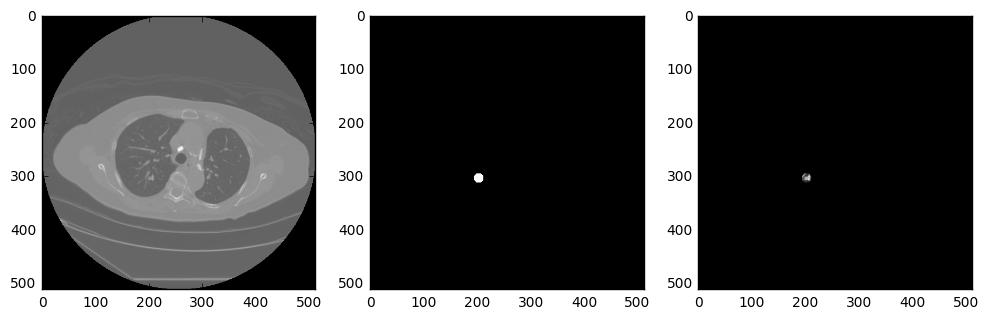

In [216]:
img = imgs[2]
mask = masks[2]

fig,ax = plt.subplots(1,3,figsize=(12, 12))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')
ax[2].imshow(img*mask,cmap='gray')
plt.show()

In [217]:
from keras.models import Model, load_model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras import backend as K
from unet import dice_coef_loss, get_unet
from keras.callbacks import ModelCheckpoint

# Show predicted segmentations

In [ ]:
spl = int(np.round(imgs.shape[0]*0.7))
tr_imgs = imgs[:5, np.newaxis, :, :]

luna = './data/luna2016/'
unet = get_unet()
#model_checkpoint = ModelCheckpoint(luna + 'unet.hdf5', monitor='loss', save_best_only=True)
unet.load_weights(luna + 'unet19.h5')

predicted = unet.predict(tr_imgs, batch_size=4)

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(16, 16))

for i in range(5):
    ax[i][0].imshow(tr_imgs[i][0],cmap='gray')
    ax[i][1].imshow(predicted[i][0],cmap='gray')
    ax[i][2].imshow(tr_imgs[i][0]*predicted[i][0],cmap='gray')
plt.show()

# Working with Kaggle's dataset

In [5]:
import dicom
from preprocessing import *
%load_ext autoreload
%autoreload 2

sample_folder = './data/kaggle/sample_images/'
patients = os.listdir(sample_folder)
patients.sort()

first_patient = load_scan(sample_folder + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


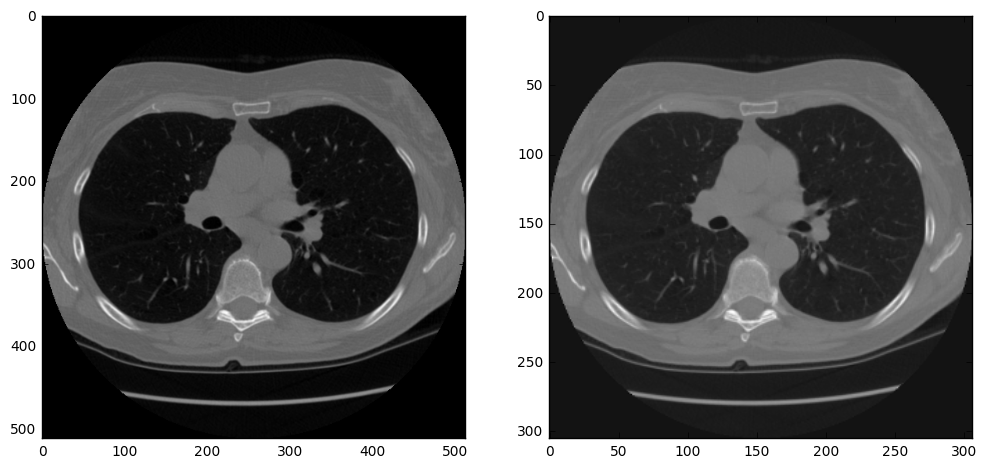

In [16]:
fig,ax = plt.subplots(1, 2,figsize=(12, 12))

ax[0].imshow(first_patient_pixels[80], cmap='gray')
ax[1].imshow(pix_resampled[200], cmap='gray')

<class 'numpy.ndarray'> <class 'int'>


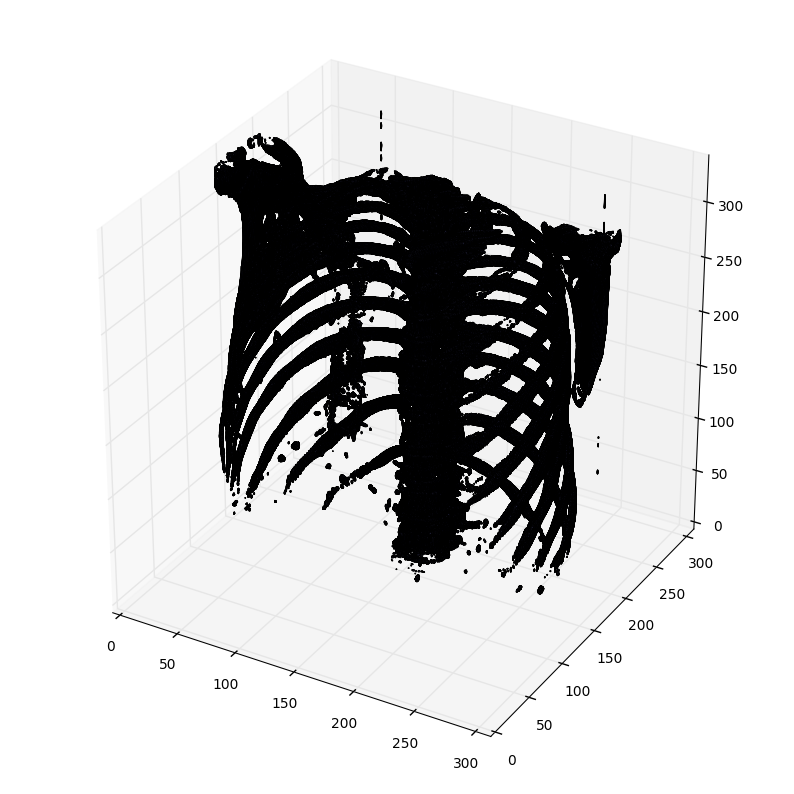

In [161]:
plot_3d(pix_resampled, 400)

# Testing predictions on the first patient

In [28]:
first_patient_masks = []

first_patient_pixels = first_patient_pixels[:, np.newaxis, :, :]

luna = './data/luna2016/'
unet = get_unet()
#model_checkpoint = ModelCheckpoint(luna + 'unet.hdf5', monitor='loss', save_best_only=True)
unet.load_weights(luna + 'unet19.h5')

predicted = unet.predict(first_patient_pixels, batch_size=4)
np.save(luna + 'first-patient-mask-predictions.npy', predicted)

# Showing a heatmap of predictions

In [63]:
all_predictions = np.zeros_like(first_patient_pixels[80][0], dtype=np.float32)

for prediction in predicted:
    all_predictions += prediction[0]

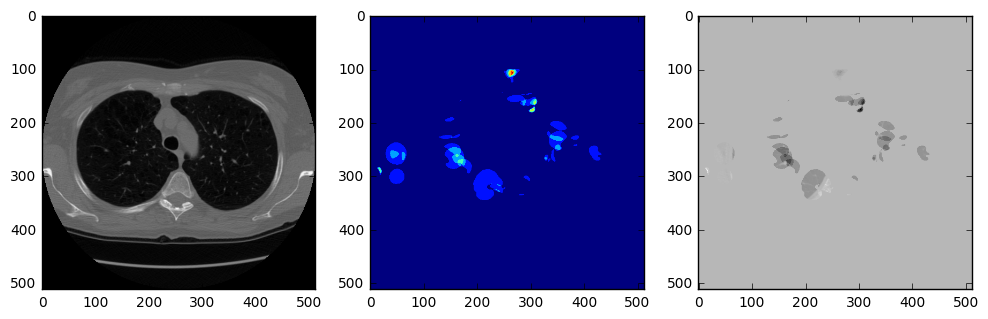

In [102]:
img = first_patient_pixels[105][0]

fig,ax = plt.subplots(1,3,figsize=(12, 12))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(all_predictions)
ax[2].imshow(img*all_predictions,cmap='gray')
plt.show()

In [122]:
import matplotlib.image as mpimg

for i, img in enumerate(cancer_patient_pixels):
    mpimg.imsave('./data/sample/cancer-patient/%d' % i, img[0], cmap='gray')

# Trying with a patient with cancer now...

In [118]:
cancer_patient = load_scan(sample_folder + '0acbebb8d463b4b9ca88cf38431aac69')
cancer_patient_pixels = get_pixels_hu(cancer_patient)

cancer_patient_pixels = cancer_patient_pixels[:, np.newaxis, :, :]

predicted = unet.predict(cancer_patient_pixels, batch_size=4)
np.save(luna + 'cancer-patient-mask-predictions.npy', predicted)

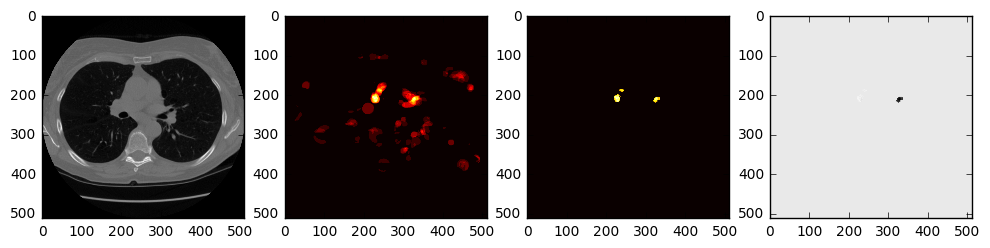

In [263]:
heatmap = np.zeros_like(first_patient_pixels[80][0], dtype=np.float32)
threshold = 8.0

for prediction in predicted:
    heatmap += prediction[0]

thresh_heatmap = np.copy(heatmap)
thresh_heatmap[thresh_heatmap <= threshold] = 0
img = first_patient_pixels[80][0]

fig,ax = plt.subplots(1,4,figsize=(12, 12))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(heatmap, cmap='hot')
ax[2].imshow(thresh_heatmap, cmap='hot')
ax[3].imshow(img*thresh_heatmap,cmap='gray')
plt.show()

In [264]:
label(thresh_heatmap)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)